## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Import Statements

In [10]:
from skimage.feature import hog

In [11]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [12]:
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import os

%matplotlib inline

In [14]:
from PIL import Image

from tensorflow.python.framework import graph_io 
from tensorflow.python.tools import freeze_graph 
from tensorflow.core.protobuf import saver_pb2 
from tensorflow.python.training import saver as saver_lib 

from keras.models import load_model 
import keras.backend as K 


Using TensorFlow backend.


In [37]:
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

ImportError: No module named pycuda.driver

### Load Training Data

In [15]:
#car_images = glob.glob('dataset/vehicles/Combined/*.jpg')
#for images in car_images:
#    print (images)
#    im = Image.open(images)
#    im2 = im.resize((64,  64), Image.BICUBIC)
#    im2.save(images.replace("jpg", "png"))


In [16]:
car_images = glob.glob('dataset/vehicles/Combined/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')[1:2000]
print(len(car_images), len(noncar_images))

(1998, 1999)


### Visualize Some of the Data

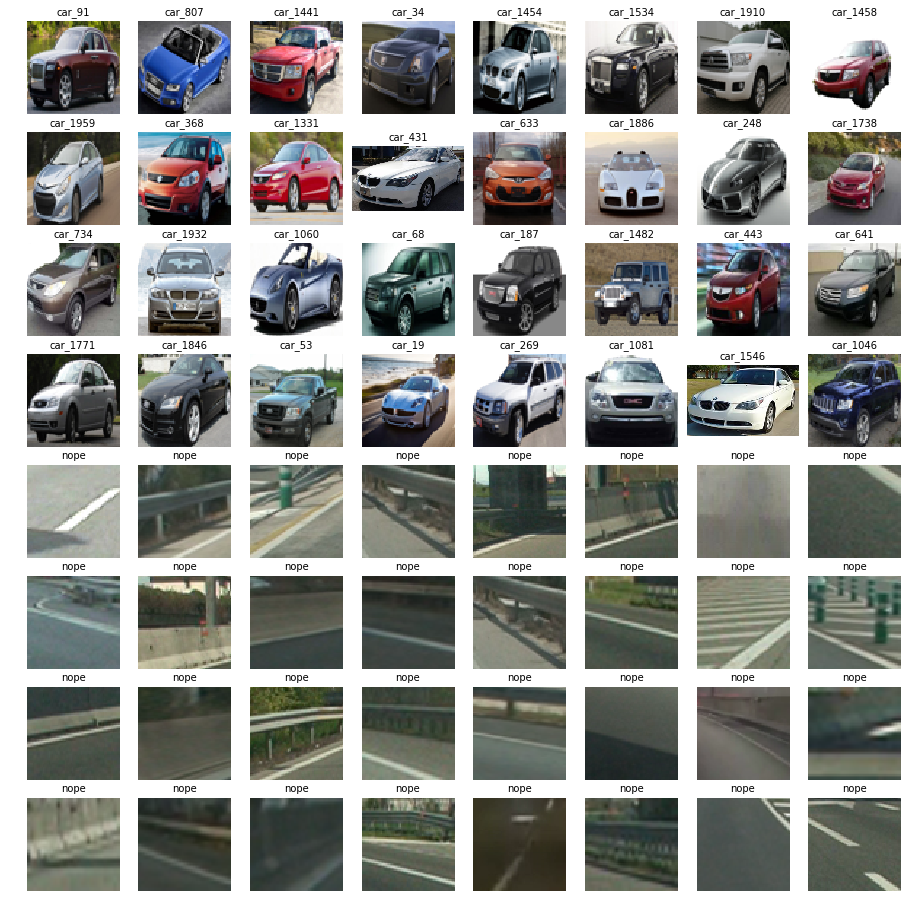

In [17]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    idx = np.random.randint(0,len(car_images))
    img = cv2.imread(car_images[idx])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car_{}'.format(idx), fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

### Define Method to Convert Image to Histogram of Oriented Gradients (HOG)

In [18]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features


Visualize HOG on example image

Text(0.5,1,'Non-Car HOG')

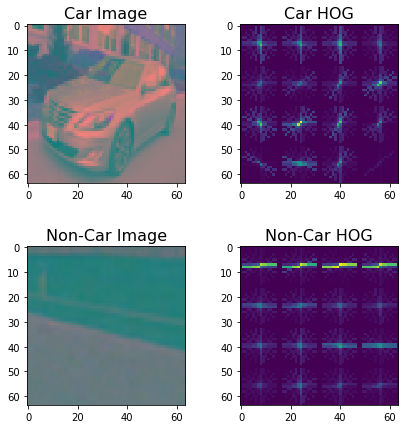

In [19]:
car_img = mpimg.imread(car_images[5])
orientations=11
pixels_per_cell=16
cells_per_block=2
feature_car_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV) # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb

# feature_car_image[:,:,2]
_, car_dst = get_hog_features(feature_car_image[:,:,0], orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
feature_noncar_image = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YUV) 

_, noncar_dst = get_hog_features(feature_noncar_image[:,:,1], orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)

ax1.imshow(feature_car_image, cmap='gray')
ax1.set_title('Car Image', fontsize=16)

ax2.imshow(car_dst)
ax2.set_title('Car HOG', fontsize=16)

ax3.imshow(feature_noncar_image, cmap='gray')
ax3.set_title('Non-Car Image', fontsize=16)

ax4.imshow(noncar_dst)
ax4.set_title('Non-Car HOG', fontsize=16)


### Method to Extract HOG Features from an Array of Car and Non-Car Images
*The code for this method was mostly duplicated from course lesson material.*

In [20]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    ignore_images = 0
    accept_images = 0
    # Iterate through the list of images
    for file in imgs:
        #print("Processing file:", file)
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)         
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if (len(feature_image.shape) > 2):
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        else:
            hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append the new feature vector to the features list
        if(hog_features.shape[0] != 1188):
            print("Ignoring ", file, hog_features.shape[0])
            ignore_images +=1
        else:
            features.append(hog_features)
            accept_images +=1
            
    print("Total Images ignored: ", ignore_images, hog_features.shape[0])
    print("Total Images accepted: ", accept_images, hog_features.shape[0])

    for f in features:
        if (f.shape[0] != 1188):
            print('Found issue')
    
    # Return list of feature vectors
    return features

### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [21]:
# Feature extraction parameters
colorspace = 'RGB' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = orientations
pix_per_cell = pixels_per_cell
cell_per_block = cells_per_block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
for c,n in zip(car_features, notcar_features):
    X = np.vstack((c,n))
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


('Ignoring ', 'dataset/vehicles/Combined/67.png', 11088)
('Ignoring ', 'dataset/vehicles/Combined/39.png', 337392)
('Ignoring ', 'dataset/vehicles/Combined/24.png', 22572)
('Ignoring ', 'dataset/vehicles/Combined/17.png', 4224)
('Ignoring ', 'dataset/vehicles/Combined/32.png', 46200)
('Ignoring ', 'dataset/vehicles/Combined/1.png', 51744)
('Ignoring ', 'dataset/vehicles/Combined/56.png', 78936)
('Ignoring ', 'dataset/vehicles/Combined/03469.png', 396)
('Ignoring ', 'dataset/vehicles/Combined/64.png', 44616)
('Ignoring ', 'dataset/vehicles/Combined/28.png', 15708)
('Ignoring ', 'dataset/vehicles/Combined/00726.png', 396)
('Ignoring ', 'dataset/vehicles/Combined/7.png', 51744)
('Ignoring ', 'dataset/vehicles/Combined/4.png', 51744)
('Ignoring ', 'dataset/vehicles/Combined/49.png', 16896)
('Ignoring ', 'dataset/vehicles/Combined/14.png', 120384)
('Ignoring ', 'dataset/vehicles/Combined/19.png', 80784)
('Ignoring ', 'dataset/vehicles/Combined/46.png', 217800)
('Ignoring ', 'dataset/vehicle

**Parameter exploration**

| Configuration Label | Colorspace | Orientations | Pixels Per Cell | Cells Per Block | HOG Channel | Extract Time |
| :-----------------: | :--------: | :----------: | :-------------: | :-------------: | :---------: | ------------:|
| 1                   | RGB        | 9            | 8               | 2               | ALL         | 71.16        |
| 2                   | HSV        | 9            | 8               | 2               | 1           | 43.74        |
| 3                   | HSV        | 9            | 8               | 2               | 2           | 36.35        |
| 4                   | LUV        | 9            | 8               | 2               | 0           | 37.42        |
| 5                   | LUV        | 9            | 8               | 2               | 1           | 38.34        |
| 6                   | HLS        | 9            | 8               | 2               | 0           | 37.42        |
| 7                   | HLS        | 9            | 8               | 2               | 1           | 42.04        |
| 8                   | YUV        | 9            | 8               | 2               | 0           | 35.86        |
| 9                   | YCrCb      | 9            | 8               | 2               | 1           | 38.32        |
| 10                  | YCrCb      | 9            | 8               | 2               | 2           | 38.99        |
| 11                  | HSV        | 9            | 8               | 2               | ALL         | 79.72        |
| 12                  | LUV        | 9            | 8               | 2               | ALL         | 78.57        |
| 13                  | HLS        | 9            | 8               | 2               | ALL         | 81.37        |
| 14                  | YUV        | 9            | 8               | 2               | ALL         | 81.82        |
| 15                  | YCrCb      | 9            | 8               | 2               | ALL         | 79.05        |
| 16                  | YUV        | 9            | 8               | 1               | 0           | 44.04        |
| 17                  | YUV        | 9            | 8               | 3               | 0           | 37.74        |
| 18                  | YUV        | 6            | 8               | 2               | 0           | 37.12        |
| 19                  | YUV        | 12           | 8               | 2               | 0           | 40.11        |
| 20                  | YUV        | 11           | 8               | 2               | 0           | 38.01        |
| 21                  | YUV        | 11           | 16              | 2               | 0           | 30.21        |
| 22                  | YUV        | 11           | 12              | 2               | 0           | 30.33        |
| 23                  | YUV        | 11           | 4               | 2               | 0           | 69.08        |
| 24                  | YUV        | 11           | 16              | 2               | ALL         | 55.20        |
| 25                  | YUV        | 7            | 16              | 2               | ALL         | 53.18        |


### Train a Classifier

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras import utils
from keras.models import load_model

In [23]:
no_of_features = 1188
y_train_oh = utils.to_categorical(y_train, num_classes=2)
y_test_oh = utils.to_categorical(y_test, num_classes=2)

In [24]:
print("Training Data shape", X_train.shape, "; Output label shape", y_train_oh.shape)

('Training Data shape', (1963, 1188), '; Output label shape', (1963, 2))


In [25]:
print("Testing Data shape", X_test.shape, "; Output label shape", y_test_oh.shape)

('Testing Data shape', (1963, 1188), '; Output label shape', (1963, 2))


In [26]:
# Use a FCN 

model = Sequential()
# Dense(1188) is a fully-connected layer with 64 hidden units.

model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
#model.add(Dropout(0.5))
model.add(Dense(int(X_train.shape[1]), activation='relu'))
model.add(Dense(int(X_train.shape[1] * 0.5), activation='relu'))


#model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', name='output_node'))

opt = Adam(lr=0.00001) #lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Check the training time
if(not os.path.exists("dataset\model.hdf5")):
    t = time.time()
    model.fit(X_train, y_train_oh,epochs=10, batch_size=100, validation_split=0.2)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train FCN...')
model.save("dataset/model.hdf5")

Train on 1570 samples, validate on 393 samples
Epoch 1/10
1570/1570 [==============================] - 3s 2ms/step - loss: 1.7758 - acc: 0.5185 - val_loss: 1.0804 - val_acc: 0.5013
Epoch 2/10
1570/1570 [==============================] - 0s 313us/step - loss: 0.6405 - acc: 0.6287 - val_loss: 0.3847 - val_acc: 0.8779
Epoch 3/10
1570/1570 [==============================] - 0s 312us/step - loss: 0.3076 - acc: 0.9045 - val_loss: 0.2625 - val_acc: 0.9109
Epoch 4/10
1570/1570 [==============================] - 0s 311us/step - loss: 0.2165 - acc: 0.9395 - val_loss: 0.2045 - val_acc: 0.9593
Epoch 5/10
1570/1570 [==============================] - 0s 312us/step - loss: 0.1678 - acc: 0.9624 - val_loss: 0.1738 - val_acc: 0.9746
Epoch 6/10
1570/1570 [==============================] - 0s 311us/step - loss: 0.1396 - acc: 0.9720 - val_loss: 0.1511 - val_acc: 0.9771
Epoch 7/10
1570/1570 [==============================] - 0s 310us/step - loss: 0.1203 - acc: 0.9777 - val_loss: 0.1379 - val_acc: 0.9771
Epo

In [34]:
model.output.name

u'output_node/Softmax:0'

In [35]:
def convert_keras_to_pb(keras_model, out_names, models_dir, model_filename): 
    model = load_model(keras_model) 
    K.set_learning_phase(0) 
    sess = K.get_session() 
    saver = saver_lib.Saver(write_version=saver_pb2.SaverDef.V2) 
    checkpoint_path = saver.save(sess, 'dataset/chkpoint/model', global_step=0, latest_filename='checkpoint_state') 
    graph_io.write_graph(sess.graph, '.', 'tmp.pb') 
    freeze_graph.freeze_graph('./tmp.pb', '', False, checkpoint_path, out_names, "save/restore_all", "save/Const:0", models_dir+model_filename, False, "")
convert_keras_to_pb('dataset/model.hdf5', 'output_node/Softmax', 'dataset/', 'model.pb')

INFO:tensorflow:Restoring parameters from dataset/chkpoint/model-0
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


In [36]:
model = load_model('dataset/model.hdf5')
# Check the score of the SVC
score = model.evaluate(X_test, y_test_oh, batch_size=128)
print('Test Accuracy of SVC = ', score)

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Example FCN predicts: ', np.argmax(model.predict(X_test[0:n_predict]), axis = 1))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with FCN')

1963/1963 [==============================] - 2s 979us/step
('Test Accuracy of SVC = ', [0.09472018560386104, 0.9831889964340296])
('Example FCN predicts: ', array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0]))
('For these', 10, 'labels: ', array([1., 1., 1., 0., 0., 1., 1., 0., 0., 0.]))
(1.92147, 'Seconds to predict', 10, 'labels with FCN')


### Method for Using Classifier to Detect Cars in an Image

In [1]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    elif hog_channel == 'GRAY':
        ch1 = ctrans_tosearch
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64

    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(10, nxsteps-10):
       
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            hog_features = hog_features.reshape(-1, no_of_features)
            test_prediction = np.argmax(svc.predict(hog_features), axis = 1)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    

### Method to Draw Rectangles onto an Image

In [2]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, `find_cars` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

test_img = mpimg.imread('./test_images/BlindSpotHD1.png')

rects = []

ystart = 450
ystop = 550
scale = 1.5

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

test_img = mpimg.imread('./test_images/BlindSpotHD2.png')

rects = []

ystart = 450
ystop = 550
scale = 1.5

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

test_img = mpimg.imread('./test_images/BlindSpotHD3.png')

rects = []

ystart = 450
ystop = 550
scale = 1.5

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

test_img = mpimg.imread('./test_images/BlindSpotHD4.png')

rects = []

ystart = 450
ystop = 550
scale = 1.5

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

test_img = mpimg.imread('./test_images/BlindSpotHD5.png')

rects = []

ystart = 450
ystop = 550
scale = 1.5

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

test_img = mpimg.imread('./test_images/BlindSpotHD6.png')

rects = []

ystart = 450
ystop = 550
scale = 1.5

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches

*Exploration findings:* 
- A scale of less than 1.0 seemed to produce a lot of false positives. 
- The start and stop positions and scales used may need some tweaking in the future, depending on video performance.

### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [3]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply a Threshold to the Heatmap

In [4]:
threshold = 10
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img.max()

heatmap_img = apply_threshold(heatmap_img.copy(), threshold)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply SciPy Labels to Heatmap

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

In [5]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        height = bbox[1][1] - bbox[0][1]
        lenght = bbox[1][0] - bbox[0][0]
        area = lenght * height 
        # Draw the box on the image
        print ("Area: ", area)
        if("areas" in locals()):
            areas.append(area)
        if (area > 9000):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Put it All Together

In [6]:
def process_frame(img):

    rectangles = []
    global colorspace
    #colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = orientations
    pix_per_cell = pixels_per_cell
    cell_per_block = cells_per_block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 450
    ystop = 550
    scale = 1.5

    for i in range(0,100,2):
        #ystart += i
        #ystop += i
        rectangles.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, threshold)
    
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

Run the pipeline on all the test images.

test_images = glob.glob('./test_images/*.*')

fig, axs = plt.subplots(8,1, figsize=(10,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


### Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames

### Define a Class to Store Data from Vehicle Detections

In [7]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 4:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-4:]

### Pipeline for Processing Video Frames

In [8]:
threshold += 5
def process_frame_for_video(img):

    rectangles = []
    global colorspace
    
    #colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = orientations
    pix_per_cell = pixels_per_cell
    cell_per_block = cells_per_block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 450
    ystop = 550
    scale = 1.5

    for i in range(0,100,2):
        #ystart += i
        #ystop += i
        rectangles.append(find_cars(img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, threshold + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


### Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

In [9]:
det = Vehicle_Detect()
areas = []
test_out_file2 = 'BlindSpot_out.webm'
clip_test2 = VideoFileClip('BlindSpot.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False, codec='libvpx')

NameError: name 'VideoFileClip' is not defined

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))